# cQAOA
The purpose of this notebook is to begin exploring the notion of cyclic QAOA (**cQAOA**).  The traditional QAOA (**QAOA**) in this notebook is taken from the following: https://quantumai.google/cirq/experiments/qaoa/qaoa_ising .  cQAOA is inspired by https://arxiv.org/pdf/2403.01034 which draws on notions of the adiabatic theorem https://en.wikipedia.org/wiki/Adiabatic_theorem , quantum annealing https://en.wikipedia.org/wiki/Quantum_annealing , and many body localization https://en.wikipedia.org/wiki/Many-body_localization .

## The Algorithm
The structure of the cQAOA algorithm is as follows:
-Select a low energy reference state.  (For initialization, you can choose any random state or begin from a single round of QAOA)

-Form the circuit of layers $\gamma$ - $\beta$ - $\alpha(t)$ where $\alpha(t)$ is the reference layer at time step t.  This is the trotterization of the Hamiltonian $H(t)=H_{cost}+H_{ref}(t)$ with boundary conditions $H_{ref}(0) = H_{ref}$ and $H_{ref}(T) = 0$.  Parameters of Trotterization should be chosen for the competing goals of 1. Maintaining adiabaticity 2. Efficiently generating a solution.  A simple initial approach is to linearly decrease the strength of the $\alpha$ layer linearly until it vanishes.  In this problem, the $\alpha$ layer is simply implemented by adjusting the local field parameters $h_i$

-Perform measurements to determine lowest energy state(s).

-Replace the low energy reference state and repeat.


## Things contained in this notebook:
QAOA Implementation following previous reference
Visualization of H(0) for cQAOA for a reference state following a round of QAOA
Rough implementation of cQAOA using gradient descent in analogy to previous reference.

## Questions:

-How best to involve classical optimization? (Is the outcome still smooth in the angles? - Suggest simply implement and see what happens first)

-How to select strength of $\alpha$ layer, referred to as refBias in cQAOA implementation.

-How to best balance number of layers between minimal circuit depth and sufficient adiabaticity?

-Is cQAOA better than QAOA? What metrics would show this?  Is it possible to analytically calculate an approximation ratio?

## To do list:
### Reimplement in more generality/ abstraction and with code optimizations. 
    -IE def QAOA(costHamiltonian(costParameters),qaoaParameters) and def cQAOA(costHamiltonian(costParameters),cqaoaParameters) for general costHamiltonians, costParameters, qaoaParameters, and cqaoaParameters

### Move towards systematic testing:
    -Optimizing qaoaParameters, cqaoaParameters for general costParameters
    -Define these parameters precisely and determine how they relate to one another

### Consider larger/ different problems with more local minima.
    -IE def toyModel(costParameters)

In [1]:
from typing import Sequence, Tuple
import numpy as np
import sympy
import matplotlib.pyplot as plt
import cirq
import copy

In [2]:
def gamma_layer(gamma_value: float, h: np.ndarray) -> Sequence[cirq.Operation]:
    """Generator for U(gamma, C) layer of QAOA

    Args:
        gamma: Float variational parameter for the circuit
        h: Array of floats of external magnetic field values
    """
    for i in range(n_rows):
        for j in range(n_cols):
            if i < n_rows - 1:
                yield cirq.ZZ(qubits[i][j], qubits[i + 1][j]) ** gamma_value
            if j < n_cols - 1:
                yield cirq.ZZ(qubits[i][j], qubits[i][j + 1]) ** gamma_value
            yield cirq.Z(qubits[i][j]) ** (gamma_value * h[i, j])

def beta_layer(beta_value: float) -> Sequence[cirq.Operation]:
    """Generator for U(beta, B) layer (mixing layer) of QAOA"""
    for row in qubits:
        for qubit in row:
            yield cirq.X(qubit) ** beta_value

In [3]:
def energy_from_wavefunction(wf: np.ndarray, h: np.ndarray) -> float:
    """Computes the energy-per-site of the Ising model directly from the
    a given wavefunction.

    Args:
        wf: Array of size 2**(n_rows * n_cols) specifying the wavefunction.
        h: Array of shape (n_rows, n_cols) giving the magnetic field values.

    Returns:
        energy: Float equal to the expectation value of the energy per site
    """
    n_sites = n_rows * n_cols

    # Z is an array of shape (n_sites, 2**n_sites). Each row consists of the
    # 2**n_sites non-zero entries in the operator that is the Pauli-Z matrix on
    # one of the qubits times the identities on the other qubits. The
    # (i*n_cols + j)th row corresponds to qubit (i,j).
    Z = np.array(
        [(-1) ** (np.arange(2**n_sites) >> i) for i in range(n_sites - 1, -1, -1)]
    )

    # Create the operator corresponding to the interaction energy summed over all
    # nearest-neighbor pairs of qubits
    ZZ_filter = np.zeros_like(wf, dtype=float)
    for i in range(n_rows):
        for j in range(n_cols):
            if i < n_rows - 1:
                ZZ_filter += Z[i * n_cols + j] * Z[(i + 1) * n_cols + j]
            if j < n_cols - 1:
                ZZ_filter += Z[i * n_cols + j] * Z[i * n_cols + (j + 1)]

    energy_operator = -ZZ_filter - h.reshape(n_sites).dot(Z)

    # Expectation value of the energy divided by the number of sites
    return np.sum(np.abs(wf) ** 2 * energy_operator) / n_sites
def energy_from_params(
    gamma_value: float, beta_value: float, qaoa: cirq.Circuit, h: np.ndarray
) -> float:
    """Returns the energy given values of the parameters."""
    sim = cirq.Simulator()
    params = cirq.ParamResolver({"𝛄": gamma_value, "β": beta_value})
    wf = sim.simulate(qaoa, param_resolver=params).final_state_vector
    return energy_from_wavefunction(wf, h)

In [4]:
"""Define problem parameters and get a set of GridQubits."""
# Set the dimensions of the grid.
n_cols = 3
n_rows = 3

# Set the value of the external magnetic field at each site.
h = 0.5 * np.ones((n_rows, n_cols))

# Arranging the qubits in a list-of-lists like this makes them easy to refer to later.
qubits = [[cirq.GridQubit(i, j) for j in range(n_cols)] for i in range(n_rows)]

"""Create the QAOA circuit."""
# Use sympy.Symbols for the 𝛾 and β parameters.
gamma = sympy.Symbol("𝛄")
beta = sympy.Symbol("β")

# Start in the H|0> state.
qaoa = cirq.Circuit(cirq.H.on_each(qubits))

# Implement the U(gamma, C) operator.
qaoa.append(gamma_layer(gamma, h))

# Implement the U(beta, B) operator.
qaoa.append(beta_layer(beta), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

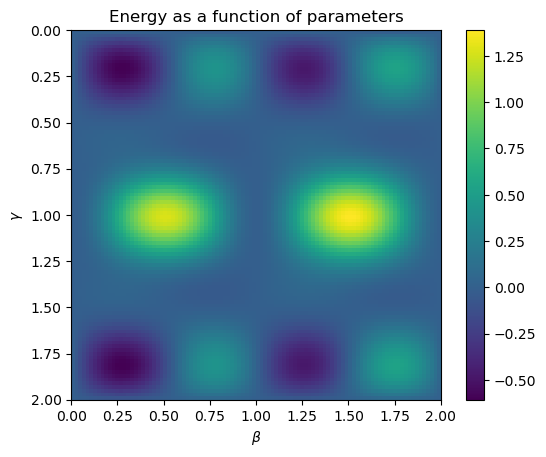

In [5]:
#"""Do a grid search over values of 𝛄 and β."""
# Set the grid size and range of parameters.
grid_size = 100
gamma_max = 2
beta_max = 2

# Do the grid search.
energies = np.zeros((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        energies[i, j] = energy_from_params(
            i * gamma_max / grid_size, j * beta_max / grid_size, qaoa, h
        )

"""Plot the energy as a function of the parameters 𝛄 and β found in the grid search."""
plt.ylabel(r"$\gamma$")
plt.xlabel(r"$\beta$")
plt.title("Energy as a function of parameters")
plt.imshow(energies, extent=(0, beta_max, gamma_max, 0))
plt.colorbar()
plt.show()

In [6]:
"""Add measurements to the QAOA circuit."""
measurement_circuit = qaoa.copy()
measurement_circuit.append(
    cirq.measure(*[qubit for row in qubits for qubit in row], key="m")
)


"""Sample from the QAOA circuit."""
num_reps = 1000  # Try different numbers of repetitions.
gamma_value, beta_value = 0.2, 0.25  # Try different values of the parameters.

# Sample from the circuit.
simulator = cirq.Simulator()
params = cirq.ParamResolver({"𝛄": gamma_value, "β": beta_value})
result = simulator.run(measurement_circuit, param_resolver=params, repetitions=num_reps)

In [7]:
def compute_energy(meas: np.ndarray) -> float:
    """Returns the energy computed from measurements.

    Args:
        meas: Measurements/samples.
    """
    Z_vals = 1 - 2 * meas.reshape(n_rows, n_cols)
    energy = 0
    for i in range(n_rows):
        for j in range(n_cols):
            if i < n_rows - 1:
                energy -= Z_vals[i, j] * Z_vals[i + 1, j]
            if j < n_cols - 1:
                energy -= Z_vals[i, j] * Z_vals[i, j + 1]
            energy -= h[i, j] * Z_vals[i, j]
    return energy / (n_rows * n_cols)

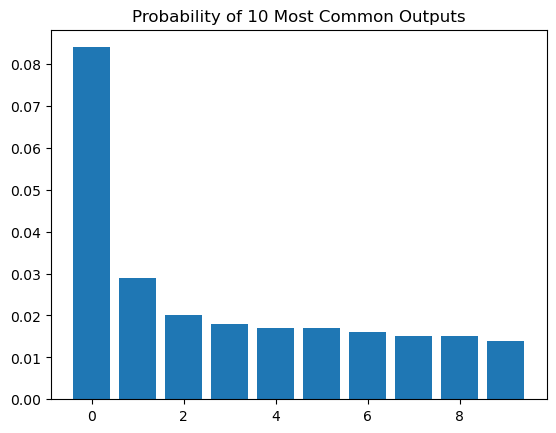

In [8]:
"""Compute the energies of the most common measurement results."""
# Get a histogram of the measurement results.
hist = result.histogram(key="m")

# Consider the top 10 of them.
num = 10

# Get the most common measurement results and their probabilities.
configs = [c for c, _ in hist.most_common(num)]
probs = [v / result.repetitions for _, v in hist.most_common(num)]

"""Plot the most common measurement results and their energies."""
# Plot probabilities of the most common bitstrings.
plt.title("Probability of {} Most Common Outputs".format(num))
plt.bar([x for x in range(len(probs))], probs)
plt.show()

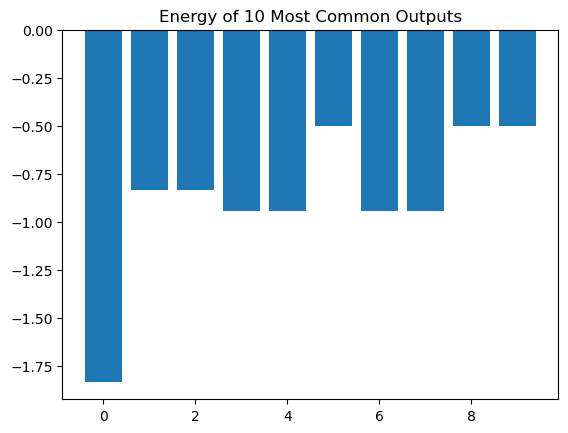

Fraction of outputs displayed: 0.24


In [9]:
meas = [
    [int(s) for s in "".join([str(b) for b in bin(k)[2:]]).zfill(n_rows * n_cols)]
    for k in configs
]
costs = [compute_energy(np.array(m)) for m in meas]
# Plot energies of the most common bitstrings.
plt.title("Energy of {} Most Common Outputs".format(num))
plt.bar([x for x in range(len(costs))], costs)
plt.show()
print("Fraction of outputs displayed: {}".format(np.sum(probs).round(2)))

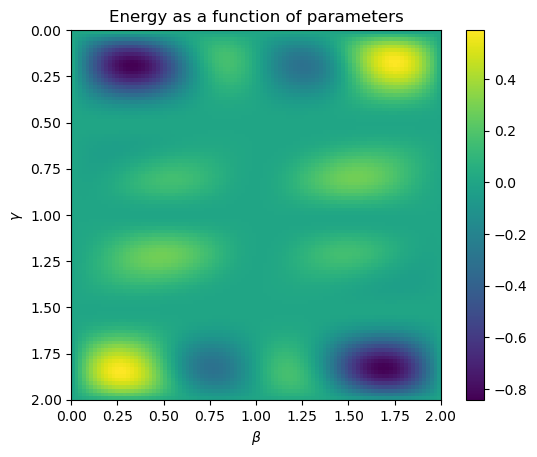

In [10]:
#Now, take most common output and recompute the energy/parameter plot from before:
# Start in the H|0> state.
rd2 = cirq.Circuit(cirq.H.on_each(qubits))
h = 0.5 * np.ones((n_rows, n_cols))
h = h - (np.array(meas[0]) - 1/2).reshape(3,3)
# Implement the U(gamma, C) operator.
rd2.append(gamma_layer(gamma, h))

# Implement the U(beta, B) operator.
rd2.append(beta_layer(beta), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)


# Do the grid search.
energies = np.zeros((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        energies[i, j] = energy_from_params(
            i * gamma_max / grid_size, j * beta_max / grid_size, rd2, h
        )

"""Plot the energy as a function of the parameters 𝛄 and β found in the grid search."""
plt.ylabel(r"$\gamma$")
plt.xlabel(r"$\beta$")
plt.title("Energy as a function of parameters")
plt.imshow(energies, extent=(0, beta_max, gamma_max, 0))
plt.colorbar()
plt.show()

Here we can see the system is further biased into the reference minimum.  In this case the reference state was already approximately the global minimum.  It may be insightful to consider biasing toward another state:

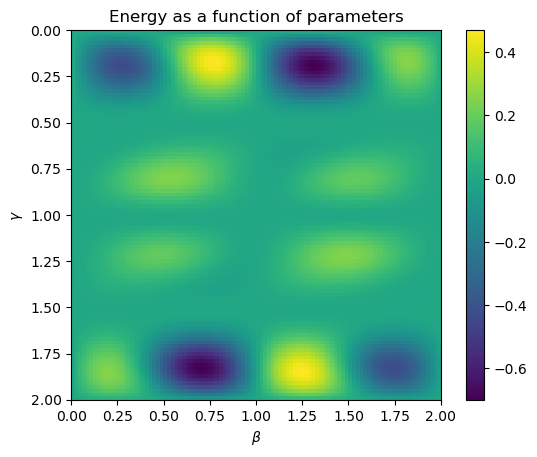

In [11]:
#Now, take most common output and recompute the energy/parameter plot from before:
# Start in the H|0> state.
rd3 = cirq.Circuit(cirq.H.on_each(qubits))
h = 0.5 * np.ones((n_rows, n_cols))
h = h - 2*(np.array(meas[1]) - 1/2).reshape(3,3)
# Implement the U(gamma, C) operator.
rd3.append(gamma_layer(gamma, h))

# Implement the U(beta, B) operator.
rd3.append(beta_layer(beta), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)


# Do the grid search.
energies = np.zeros((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        energies[i, j] = energy_from_params(
            i * gamma_max / grid_size, j * beta_max / grid_size, rd2, h
        )

"""Plot the energy as a function of the parameters 𝛄 and β found in the grid search."""
plt.ylabel(r"$\gamma$")
plt.xlabel(r"$\beta$")
plt.title("Energy as a function of parameters")
plt.imshow(energies, extent=(0, beta_max, gamma_max, 0))
plt.colorbar()
plt.show()

So now we can see that we have biased the system toward a local minima.  Hopefully from this state cQAOA can adiabatically discover the global minimum.  Let's look at implementing classical optimization into QAOA:

In [111]:
def gradient_energy(
    gamma: float, beta: float, qaoa: cirq.Circuit, h: np.ndarray
) -> Tuple[float, float]:
    """Uses a symmetric difference to calculate the gradient."""
    eps = 10**-2  # Try different values of the discretization parameter

    # Gamma-component of the gradient
    grad_g = energy_from_params(gamma + eps, beta, qaoa, h)
    grad_g -= energy_from_params(gamma - eps, beta, qaoa, h)
    grad_g /= 2 * eps

    # Beta-compoonent of the gradient
    grad_b = energy_from_params(gamma, beta + eps, qaoa, h)
    grad_b -= energy_from_params(gamma, beta - eps, qaoa, h)
    grad_b /= 2 * eps

    return grad_g, grad_b

In [112]:
"""Run a simple gradient descent optimizer."""
gamma, beta = 0.2, 1.2  # Try different initializations
eta = 10**-2  # Try adjusting the learning rate.
h = 0.5 * np.ones((n_rows, n_cols))

# Perform gradient descent for a given number of steps.
num_steps = 150
for i in range(num_steps + 1):
    # Compute the gradient.
    grad_g, grad_b = gradient_energy(gamma, beta, qaoa, h)

    # Update the parameters.
    gamma -= eta * grad_g
    beta -= eta * grad_b

    # Status updates.
    if not i % 5:
        print("Step: {} Energy: {}".format(i, energy_from_params(gamma, beta, qaoa, h)))

print("\nLearned gamma: {}\nLearned beta: {}".format(gamma, beta, qaoa, h))

Step: 0 Energy: -0.46229841464865884
Step: 5 Energy: -0.4760345426051976
Step: 10 Energy: -0.4776570862266251
Step: 15 Energy: -0.4778442148882378
Step: 20 Energy: -0.47786538661502065
Step: 25 Energy: -0.47786796729400927
Step: 30 Energy: -0.47786822734774936
Step: 35 Energy: -0.4778682594720117
Step: 40 Energy: -0.4778684238866238
Step: 45 Energy: -0.4778681862380836
Step: 50 Energy: -0.47786823785544486
Step: 55 Energy: -0.4778684950403355
Step: 60 Energy: -0.4778682487501808
Step: 65 Energy: -0.47786834045139887
Step: 70 Energy: -0.47786854869779444
Step: 75 Energy: -0.47786812547585417
Step: 80 Energy: -0.4778683643851562
Step: 85 Energy: -0.4778682184292443
Step: 90 Energy: -0.47786828558582783
Step: 95 Energy: -0.47786825292708573
Step: 100 Energy: -0.4778680546242968
Step: 105 Energy: -0.47786834207050155
Step: 110 Energy: -0.47786859553525574
Step: 115 Energy: -0.47786822283109764
Step: 120 Energy: -0.4778685739761891
Step: 125 Energy: -0.47786847672432486
Step: 130 Energy: -0

Cool, that works (Thanks Google!).  Let's look at changing the circuit to have multiple layers, but otherwise keep the algorithm the same:

In [116]:
layers=20
h = 0.5 * np.ones((n_rows, n_cols))
gamma = sympy.Symbol("𝛄")
beta = sympy.Symbol("β")

qaoa3 = cirq.Circuit(cirq.H.on_each(qubits))
for i in range(layers):
    # Implement the U(gamma, C) operator.
    qaoa3.append(gamma_layer(gamma, h))
    
    # Implement the U(beta, B) operator.
    qaoa3.append(beta_layer(beta), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
    
gamma, beta = 0.2, 1.2  # Try different initializations
eta = 10**-3  # Try adjusting the learning rate.
# Perform gradient descent for a given number of steps.
num_steps = 50
for i in range(num_steps + 1):
    # Compute the gradient.
    grad_g, grad_b = gradient_energy(gamma, beta, qaoa3, h)
    
    # Update the parameters.
    gamma -= eta * grad_g
    beta -= eta * grad_b

    # Status updates.
    if not i % 5:
        print("Step: {} Energy: {}".format(i, energy_from_params(gamma, beta, qaoa3, h)))

print("\nLearned gamma: {}\nLearned beta: {}".format(gamma, beta, qaoa3, h))

Step: 0 Energy: -0.45142468316367335
Step: 5 Energy: -0.5771526638461384
Step: 10 Energy: -0.5770376668113184
Step: 15 Energy: -0.5770326625035724
Step: 20 Energy: -0.5770307529195028
Step: 25 Energy: -0.5770279707993622
Step: 30 Energy: -0.5770233633403828
Step: 35 Energy: -0.5770274939944405
Step: 40 Energy: -0.5770270970711459
Step: 45 Energy: -0.5770325476739546
Step: 50 Energy: -0.5770298425890764

Learned gamma: 0.2114701442233884
Learned beta: 1.186852483101907


In [126]:
layers=40
h = 0.5 * np.ones((n_rows, n_cols))
gamma = sympy.Symbol("𝛄")
beta = sympy.Symbol("β")
refBias=0.1

cqaoa = cirq.Circuit(cirq.H.on_each(qubits))
for i in range(layers):
    # Implement the U(gamma, C) operator.
    cqaoa.append(gamma_layer(gamma, h))
    
    # Implement the U(beta, B) operator.
    cqaoa.append(beta_layer(beta), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
gamma, beta = 0.2, 1.2  # Try different initializations
eta = 10**-4  # Try adjusting the learning rate.
# Perform gradient descent for a given number of steps.
num_steps = 50
for i in range(num_steps + 1):
    # Compute the gradient.
    grad_g, grad_b = gradient_energy(gamma, beta, cqaoa, h)
    
    # Update the parameters.
    gamma -= eta * grad_g
    beta -= eta * grad_b

    """Add measurements to the QAOA circuit."""
    measurement_circuit = cqaoa.copy()
    measurement_circuit.append(
        cirq.measure(*[qubit for row in qubits for qubit in row], key="m")
    )
    
    
    """Sample from the QAOA circuit."""
    num_reps = 10000  # Try different numbers of repetitions.
    gamma_value, beta_value = gamma, beta  # Try different values of the parameters.
    
    # Sample from the circuit.
    simulator = cirq.Simulator()
    params = cirq.ParamResolver({"𝛄": gamma_value, "β": beta_value})
    result = simulator.run(measurement_circuit, param_resolver=params, repetitions=num_reps)

    hist = result.histogram(key="m")

    # Consider the top 10 of them.
    num = 10
    
    # Get the most common measurement results and their probabilities.
    configs = [c for c, _ in hist.most_common(num)]
    meas = [
    [int(s) for s in "".join([str(b) for b in bin(k)[2:]]).zfill(n_rows * n_cols)]
    for k in configs
    ]
    hupdate = - 2*(np.array(meas[0]) - 1/2).reshape(3,3)
    gamma = sympy.Symbol("𝛄")
    beta = sympy.Symbol("β")

    cqaoa = cirq.Circuit(cirq.H.on_each(qubits))
    for j in range(layers-1,-1,-1):
        # Implement the U(gamma, C) operator.
        cqaoa.append(gamma_layer(gamma, h))
        
        # Implement the U(beta, B) operator.
        cqaoa.append(beta_layer(beta), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
        cqaoa.append(gamma_layer(refBias*j/layers, hupdate))
    
    gamma = gamma_value
    beta = beta_value
    # Status updates.
    if not i % 5:
        print("Step: {} Energy: {}".format(i, energy_from_params(gamma, beta, cqaoa, h)))

print("\nLearned gamma: {}\nLearned beta: {}".format(gamma, beta, cqaoa, h))

Step: 0 Energy: -0.17675616361086416
Step: 5 Energy: -0.1870233890446242
Step: 10 Energy: -0.181671841276006
Step: 15 Energy: -0.38144631691046194
Step: 20 Energy: -0.4153806596328498
Step: 25 Energy: -0.42339035257848284
Step: 30 Energy: -0.42523995339059995
Step: 35 Energy: -0.4256999034827105
Step: 40 Energy: -0.42583572329546215
Step: 45 Energy: -0.42590229428272625
Step: 50 Energy: -0.42592202617024416

Learned gamma: 0.18619459245454478
Learned beta: 1.1916369148038362


So this seems to work, at least for small refBias.  To get a better sense of how this could work, we need to initialize both algorithms to a different starting state:

In [128]:
layers=10
h = 0.5 * np.ones((n_rows, n_cols))
gamma = sympy.Symbol("𝛄")
beta = sympy.Symbol("β")

qaoa3 = cirq.Circuit(cirq.H.on_each(qubits))
for i in range(layers):
    # Implement the U(gamma, C) operator.
    qaoa3.append(gamma_layer(gamma, h))
    # Implement the U(beta, B) operator.
    qaoa3.append(beta_layer(beta), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
gamma, beta = 0.2, 1.3  # Try different initializations
eta = 10**-4 # Try adjusting the learning rate.
# Perform gradient descent for a given number of steps.
num_steps = 300
for i in range(num_steps + 1):
    # Compute the gradient.
    grad_g, grad_b = gradient_energy(gamma, beta, qaoa3, h)
    
    # Update the parameters.
    gamma -= eta * grad_g
    beta -= eta * grad_b

    # Status updates.
    if not i % 10:
        print("Step: {} Energy: {}".format(i, energy_from_params(gamma, beta, qaoa3, h)))

print("\nLearned gamma: {}\nLearned beta: {}".format(gamma, beta, qaoa3, h))

Step: 0 Energy: -0.4506300678796278
Step: 10 Energy: -0.4613722907570011
Step: 20 Energy: -0.48217566453230476
Step: 30 Energy: -0.5148884501419767
Step: 40 Energy: -0.5478055311790513
Step: 50 Energy: -0.5675146115262982
Step: 60 Energy: -0.5755814015226153
Step: 70 Energy: -0.5783330383641088
Step: 80 Energy: -0.5792481744632849
Step: 90 Energy: -0.5795771736697096
Step: 100 Energy: -0.5797170496505986
Step: 110 Energy: -0.5797914955014234
Step: 120 Energy: -0.579841719291055
Step: 130 Energy: -0.5798746313189093
Step: 140 Energy: -0.5799086492779458
Step: 150 Energy: -0.5799253272423294
Step: 160 Energy: -0.579944245585807
Step: 170 Energy: -0.5799583094473127
Step: 180 Energy: -0.5799666454246272
Step: 190 Energy: -0.5799703978174952
Step: 200 Energy: -0.5799769083316733
Step: 210 Energy: -0.5799845203874648
Step: 220 Energy: -0.579983309569583
Step: 230 Energy: -0.5799910764043008
Step: 240 Energy: -0.5799918335585453
Step: 250 Energy: -0.5799954324806309
Step: 260 Energy: -0.5799

In [130]:
layers=10
h = 0.5 * np.ones((n_rows, n_cols))
gamma = sympy.Symbol("𝛄")
beta = sympy.Symbol("β")
refBias=0.1

cqaoa = cirq.Circuit(cirq.H.on_each(qubits))
for i in range(layers):
    # Implement the U(gamma, C) operator.
    cqaoa.append(gamma_layer(gamma, h))
    
    # Implement the U(beta, B) operator.
    cqaoa.append(beta_layer(beta), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
gamma, beta = 0.2, 1.3  # Try different initializations
eta = 10**-4  # Try adjusting the learning rate.
# Perform gradient descent for a given number of steps.
num_steps = 300
for i in range(num_steps + 1):
    # Compute the gradient.
    grad_g, grad_b = gradient_energy(gamma, beta, cqaoa, h)
    
    # Update the parameters.
    gamma -= eta * grad_g
    beta -= eta * grad_b

    """Add measurements to the QAOA circuit."""
    measurement_circuit = cqaoa.copy()
    measurement_circuit.append(
        cirq.measure(*[qubit for row in qubits for qubit in row], key="m")
    )
    
    
    """Sample from the QAOA circuit."""
    num_reps = 10000  # Try different numbers of repetitions.
    gamma_value, beta_value = gamma, beta  # Try different values of the parameters.
    
    # Sample from the circuit.
    simulator = cirq.Simulator()
    params = cirq.ParamResolver({"𝛄": gamma_value, "β": beta_value})
    result = simulator.run(measurement_circuit, param_resolver=params, repetitions=num_reps)

    hist = result.histogram(key="m")

    # Consider the top 10 of them.
    num = 10
    
    # Get the most common measurement results and their probabilities.
    configs = [c for c, _ in hist.most_common(num)]
    meas = [
    [int(s) for s in "".join([str(b) for b in bin(k)[2:]]).zfill(n_rows * n_cols)]
    for k in configs
    ]
    hupdate = - 2*(np.array(meas[0]) - 1/2).reshape(3,3)
    gamma = sympy.Symbol("𝛄")
    beta = sympy.Symbol("β")

    cqaoa = cirq.Circuit(cirq.H.on_each(qubits))
    for j in range(layers-1,-1,-1):
        # Implement the U(gamma, C) operator.
        cqaoa.append(gamma_layer(gamma, h))
        
        # Implement the U(beta, B) operator.
        cqaoa.append(beta_layer(beta), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
        cqaoa.append(gamma_layer(refBias*j/layers, hupdate))
    
    gamma = gamma_value
    beta = beta_value
    # Status updates.
    if not i % 10:
        print("Step: {} Energy: {}".format(i, energy_from_params(gamma, beta, cqaoa, h)))

print("\nLearned gamma: {}\nLearned beta: {}".format(gamma, beta, cqaoa, h))

Step: 0 Energy: -0.5875593422559733
Step: 10 Energy: -0.55337007943884
Step: 20 Energy: -0.5984608611019616
Step: 30 Energy: -0.6200395527219926
Step: 40 Energy: -0.6291491802874892
Step: 50 Energy: -0.6329718834989662
Step: 60 Energy: -0.6346016480879876
Step: 70 Energy: -0.6352897232086434
Step: 80 Energy: -0.6355515683491527
Step: 90 Energy: -0.6356313317632056
Step: 100 Energy: -0.6356222050149477
Step: 110 Energy: -0.6355734167110414
Step: 120 Energy: -0.6355114475053496
Step: 130 Energy: -0.6219521805285998
Step: 140 Energy: -0.6355714936282513
Step: 150 Energy: -0.6355122926789186
Step: 160 Energy: -0.6354543372419559
Step: 170 Energy: -0.6355815634736549
Step: 180 Energy: -0.6355230499974722
Step: 190 Energy: -0.6354659897556808
Step: 200 Energy: -0.6355977934871488
Step: 210 Energy: -0.6355347413248941
Step: 220 Energy: -0.635637035772662
Step: 230 Energy: -0.6355862833822054
Step: 240 Energy: -0.6355287132624249
Step: 250 Energy: -0.6354713222483244
Step: 260 Energy: -0.63542

Some final thoughts on my explorations:

-The important parameters to tune in the cQAOA seem to be refBias (How strong the reference is), epsilon (spatial step for gradient), and eta (step size taken in gradient direction a la gradient descent), and number of circuit layers.  In particular, for larger refBias, more circuit layers seem to be required.  Eta and epsilon seem to have the usual problems of gradient descent, but seem more sensitive in the case of cQAOA.  At least in this (rough) implementation, it seems it is possible to pick parameters that make either method look better but generally it seems cQAOA is more likely to find a lower minimum than QAOA for a given set of inputs.  (See last 2 runs as an example).

Question: Is it possible that cQAOA is benefiting from the sensitivity? IE, is it just finding deeper wells by chance?  Would we be just as well off by introducing noise?  Perhaps improving the classical optimization step could provide some insight to this?